In [3]:
# Standard library imports
import os
from PIL import Image

# Third-party library imports
import numpy as np
import cv2
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


In [4]:
data_dir = 'Data'
# classes but only the directories
files = os.listdir(data_dir)
classes = [f for f in files if os.path.isdir(os.path.join(data_dir, f))]

classes.sort()

0: 100
1: 100
2: 100
3: 100
4: 100
5: 100
6: 100
7: 100
8: 100
9: 100


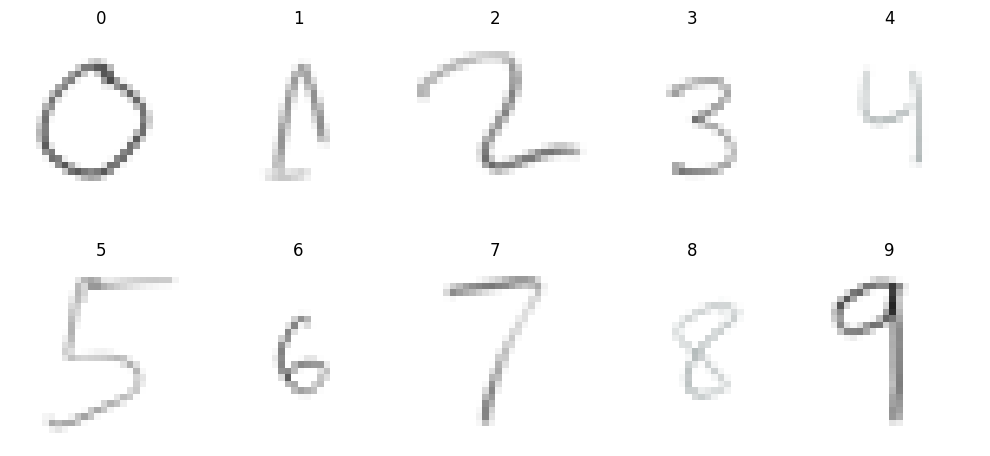

In [7]:
X = []
y = []

for i, c in enumerate(classes):
    files = os.listdir(os.path.join(data_dir, c))
    files = [f for f in files if f.endswith('.png')]
    print(f'{c}: {len(files)}')

    for f in files:
        img = Image.open(os.path.join(data_dir, c, f))
        img = img.resize((28, 28))
        img = np.array(img)
        img = img / 255
        img = img.astype(np.float32)
        # Check the shape of the image after resizing
        X.append(img)
        y.append(i)

# Convert lists to arrays
X = np.array(X)
y = np.array(y)


fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i in range(10):
    
    # print off 1 image from each class
    idx = np.where(y == i)[0][0]
    axes[i].imshow(X[idx])
    axes[i].set_title(classes[y[idx]])
    axes[i].axis('off')
    

plt.tight_layout()
plt.show()


In [8]:
# print the shape of the arrays
print(X.shape)
print(y.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Save the data
try:
    np.save('npFiles/X_train.npy', X_train)
    np.save('npFiles/X_test.npy', X_test)
    np.save('npFiles/y_train.npy', y_train)
    np.save('npFiles/y_test.npy', y_test)
    np.save('npFiles/classes.npy', classes)
    print('Data saved successfully')
except Exception as e:
    print(f'Error saving data: {e}')


(1000, 28, 28, 4)
(1000,)
Data saved successfully


In [11]:
# Load the data
X_train = np.load('npFiles/X_train.npy')
X_test = np.load('npFiles/X_test.npy')
y_train = np.load('npFiles/y_train.npy')
y_test = np.load('npFiles/y_test.npy')
classes = np.load('npFiles/classes.npy')

print('Data loaded')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(classes)



Data loaded
(800, 28, 28, 4)
(200, 28, 28, 4)
(800, 10)
(200, 10)
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


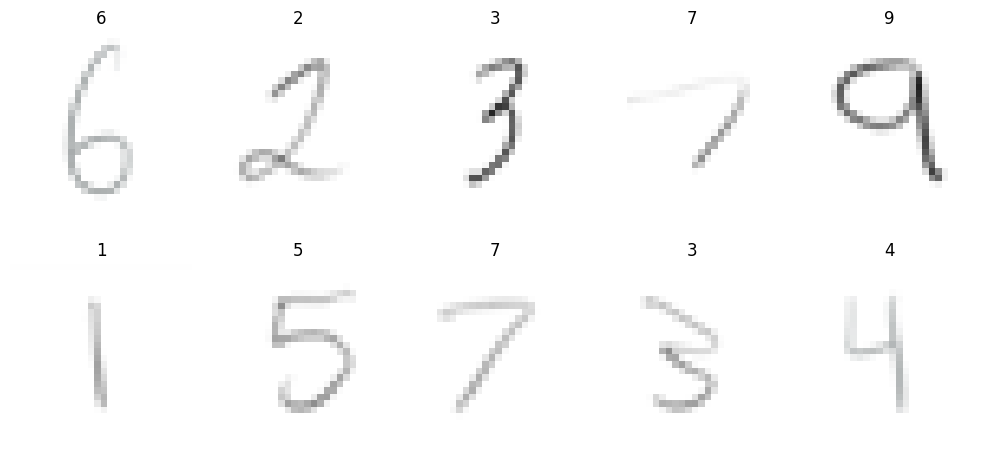

In [12]:
# print a random sample images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i in range(10):
    idx = np.random.randint(0, X_train.shape[0])
    axes[i].imshow(X_train[idx])
    axes[i].set_title(classes[np.argmax(y_train[idx])])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [13]:
# data augmentation
datagen = ImageDataGenerator(
      rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

augmented_X = []
augmented_y = []

# Generate augmented data for each sample in the dataset
for i in range(len(X_train)):
    X_train_example = X_train[i].reshape((1, 28, 28, 4))
    y_train_example = y_train[i].reshape((1, 10))
    num_augmented_samples = 5  # You can adjust the number of augmented samples per original sample
    for _ in range(num_augmented_samples):
        X_train_augmented, y_train_augmented = datagen.flow(X_train_example, y_train_example).__next__()
        # Reshape augmented data to remove extra dimension
        X_train_augmented = X_train_augmented.squeeze(axis=0)
        y_train_augmented = y_train_augmented.squeeze(axis=0)
        augmented_X.append(X_train_augmented)
        augmented_y.append(y_train_augmented)

# Convert lists to numpy arrays
augmented_X = np.array(augmented_X)
augmented_y = np.array(augmented_y)

# Print the shape of the augmented dataset
print("Shape of augmented dataset:", augmented_X.shape)
print("Shape of augmented labels:", augmented_y.shape)


Shape of augmented dataset: (4000, 28, 28, 4)
Shape of augmented labels: (4000, 10)


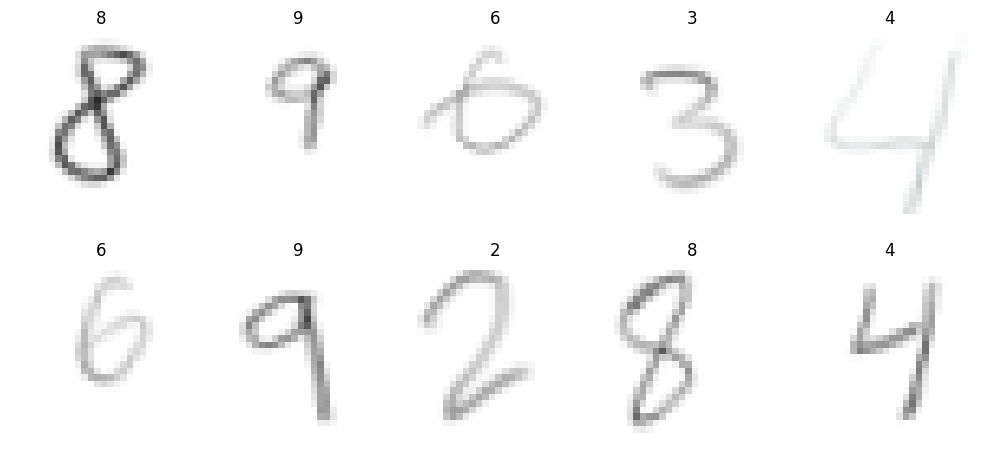

In [25]:
# print images after augmentation
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i in range(10):
    idx = np.random.randint(0, augmented_X.shape[0])
    axes[i].imshow(augmented_X[idx])
    axes[i].set_title(classes[np.argmax(augmented_y[idx])])
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [22]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu', input_shape=(28, 28, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


def intialize_model_train(epoch, batch_size):
	print("******* training network *******")
# Compile the model with Adam optimizer
	adam_optimizer = Adam(learning_rate=0.001)  # You can adjust the learning rate as needed
	model.compile(loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"])
	# go through the data 5 times with 128 batch sizes
	H = model.fit(augmented_X,augmented_y, validation_data=(X_test, y_test),
		epochs=epoch, batch_size=batch_size)

	# evaluate the network
	print("******* evaluating network *******")
	predictions = model.predict(X_test, batch_size=batch_size)
	print(classification_report(y_test.argmax(axis=1),
		predictions.argmax(axis=1)))

In [23]:
intialize_model_train(8,50)

******* training network *******
Epoch 1/8
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.0983 - loss: 2.3109 - val_accuracy: 0.0750 - val_loss: 2.3080
Epoch 2/8
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.1011 - loss: 2.3024 - val_accuracy: 0.0650 - val_loss: 2.3095
Epoch 3/8
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.1172 - loss: 2.3011 - val_accuracy: 0.0750 - val_loss: 2.3048
Epoch 4/8
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.1363 - loss: 2.2737 - val_accuracy: 0.5100 - val_loss: 1.7841
Epoch 5/8
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3344 - loss: 1.8718 - val_accuracy: 0.7450 - val_loss: 0.9954
Epoch 6/8
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5448 - loss: 1.3257 - val_accuracy: 0.8500 - val_loss: 0.6382
Epoch 7/8
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6422 - loss: 1.0242 - val_accuracy: 0.8550 - val_loss: 0.4632
Epoch 8/8
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7289 - loss: 0.7976 -

In [24]:
def Save_Model(model):
    #os.chdir("SavedModels")
    model.save("SavedModels/NN.keras")

Save_Model(model)